In [1]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, ToolMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [2]:
load_dotenv()

True

In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [4]:
@tool
def add(a: int, b: int):
    """This is an addition function that adds 2 numbers together"""
    return a + b

In [5]:
tools = [add]

In [6]:
model = ChatOpenAI(model="gpt-4o")

In [7]:
model = model.bind_tools(tools)

In [9]:
def model_call(state: AgentState) -> AgentState:
    """"""
    system_prompt = SystemMessage(content="You are my AI assistant, please answer my query to the best of your ability")
    response = model.invoke([system_prompt] + state['messages'])
    return {"messages":[response]}

In [10]:
def should_continue(state:AgentState) -> str:
    """"""
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [12]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)
graph.set_entry_point("our_agent")
graph.add_conditional_edges("our_agent", 
                            should_continue, 
                            {
                            "continue":"tools",
                            "end": END,
                            },
)

In [13]:
graph.add_edge("tools", "our_agent")

In [14]:
app = graph.compile()

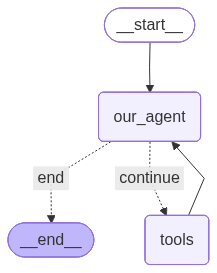

In [15]:
app

In [16]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [18]:
inputs = {"message": [("user", "Add 40 + 12.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================== Ai Message ==================================

How can I assist you today?
